* This notebook run the KR model on multiple dates to obtain estimates for discount curves and log yield curves. Price and cashflow matrices are generated by `construct_input_price_and_cashflow.ipynb'. 
* For fixed kernel parameters $\alpha$ and $\delta$, a kernel matrix is generated once and shared across all dates.
* Filter: remove securities maturing within 90 days for the fitting process.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sps 
import time
import sys
import os
import pickle
from tqdm.auto import tqdm

sys.path.append('./src/')
import kr_model
import kr_utils

# Settings

In [2]:
# KR settings
alpha = 0.05
delta = 0.0
ridge = 1.0

# data setting
dir_data = './B_and_C/'

# where to save output
dir_output = './KR_estimates/'
if not os.path.exists(dir_output):
    os.makedirs(dir_output)

# Load data and parameters

In [3]:
# read parameters
with open(dir_data+"dict_par.pkl", "rb") as handle:
    dict_par = pickle.load(handle)
Nmax = dict_par['Nmax']
dir_C = dict_par['dir_C']
display(dict_par)

# load data
df_B_mat = pd.read_pickle(dir_data+'df_B_mat.pkl') # dataframe with read price vectors
df_nt = pd.read_pickle(dir_data+'df_nt.pkl') # number of observations per day

{'T_slice': 252,
 'Nmax': 11315,
 'Nmax_C': 11316,
 'nmax': 380,
 'first_date': Timestamp('2021-01-01 00:00:00'),
 'last_date': Timestamp('2021-12-31 00:00:00'),
 'prefix_C': 'C_30yr_',
 'dir_C': './B_and_C/C_npz/',
 'removal_maturities': [2, 3, 4, 5, 7, 10, 20, 30]}

# Generate the kernel matrix for fixed $\alpha$ and $\delta$

In [4]:
start_time=time.time()
K=kr_model.generate_kernel_matrix(alpha, delta, Nmax, Nmax)
end_time=time.time()

print('Time elapsed for generating a {}-by-{} kernel matrix with alpha = {} and delta = {}: {:.1f} sec'\
      .format(Nmax, Nmax, alpha, delta, end_time-start_time))

Time elapsed for generating a 11315-by-11315 kernel matrix with alpha = 0.05 and delta = 0.0: 9.4 sec


# Fit KR model for each date

In [5]:
T = len(df_B_mat) # number of time periods
# preallocate storage
g_mat = np.full((T, Nmax), np.nan) # solved discount curves
y_mat = np.full((T, Nmax), np.nan) # implied yield curves

pbar = tqdm(total=T)
start_time = time.time()
for t in range(T):
    date = df_B_mat.index[t]

    # get price vector
    nt = df_nt.nt[t]
    B = df_B_mat.iloc[t][:nt].values

    # load cashflow matrix and remove the first column that corresponds to cashflow due today, 
    # which is 0 by construction
    C = sps.load_npz(dir_C+'{}{}.npz'.format(dict_par['prefix_C'], date.strftime('%Y-%m-%d'))).toarray()[:nt,1:]

    # filter out securities maturing within 90 days
    # get time to maturity in days for filtering
    ttm = np.where(C>=100)[1]+1
    B = B[ttm>=90]
    C = C[ttm>=90]
    nt = len(B)

    # get YTM and duration
    ytm, dur=np.zeros(nt), np.zeros(nt) # YTM and duration
    ttm = np.zeros(nt) # time to maturity in days
    for i in range(nt):
        time_to_cashflow_inday=np.where(C[i]!=0)[0]+1
        ytm[i], dur[i] = kr_utils.get_ytm_and_duration(C[i][time_to_cashflow_inday-1], time_to_cashflow_inday, B[i])
        ttm[i] = max(time_to_cashflow_inday)

    # get inverse of weights for fitting
    # weights w is computed as w=1/inv_w
    inv_w=(dur*B)**2*nt

    # fit KR
    dict_fit=kr_model.KR(C=C, # cashflow matrix
                         B=B, # price vector
                         ridge=ridge, # ridge hyper-parameter
                         inv_w=inv_w, # inverse of the weighting vector
                         K=K # kernel matrix
                        )

    g_mat[t] = dict_fit['g_solved']
    y_mat[t] = dict_fit['y_solved']
    pbar.update(1)
    
end_time=time.time()
print('Time elapsed for fitting KR model on {} days: {:.1f} min'\
         .format(T, (end_time - start_time)/60))

# aligned with dates and maturity indexes
df_g = pd.DataFrame(index=df_B_mat.index, data=g_mat, columns=np.arange(1,1+Nmax))
df_y = pd.DataFrame(index=df_B_mat.index, data=y_mat, columns=np.arange(1,1+Nmax))

# save estimates
df_g.to_pickle(dir_output+'df_g.pkl')
df_y.to_pickle(dir_output+'df_y.pkl')


  0%|          | 0/252 [00:00<?, ?it/s]

Time elapsed for fitting KR model on 252 days: 2.9 min


# Make plots

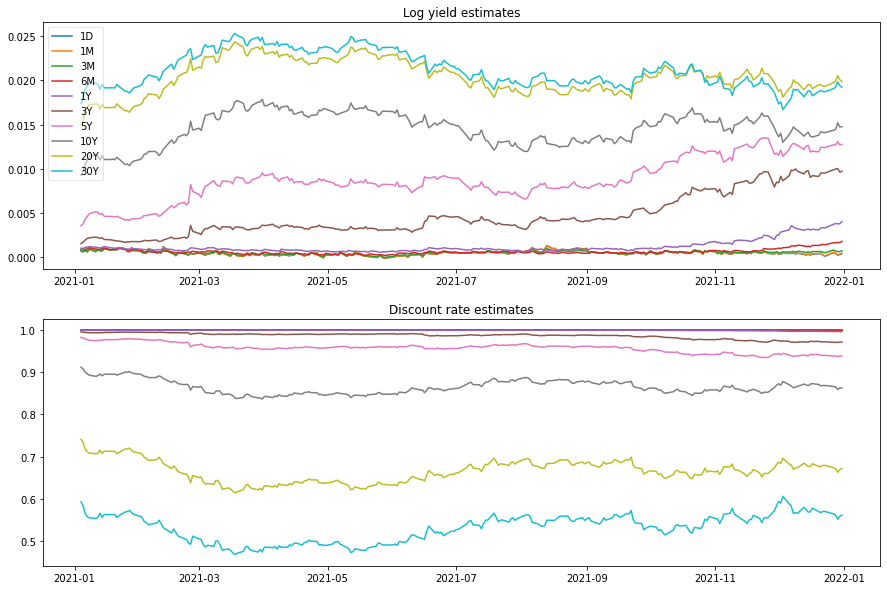

In [6]:
maturities = [1, 30, 90, 180, 365, 3*365, 5*365, 10*365, 20*365, 30*365]
labels = ['1D', '1M', '3M', '6M', '1Y', '3Y', '5Y', '10Y', '20Y', '30Y']

fig = plt.figure(figsize=(15, 2*5))
ax_1, ax_2 = fig.add_subplot(2,1,1), fig.add_subplot(2,1,2)

for maturity, label in zip(maturities, labels):
    ax_1.plot(df_y[maturity], label=label)
    ax_2.plot(df_g[maturity], label=label)

for ax in [ax_1]:
    ax.legend(framealpha = 0.5);
    
ax_1.set_title('Log yield estimates');
ax_2.set_title('Discount rate estimates');

fig.savefig(dir_output+'estimates_timeseries.png')

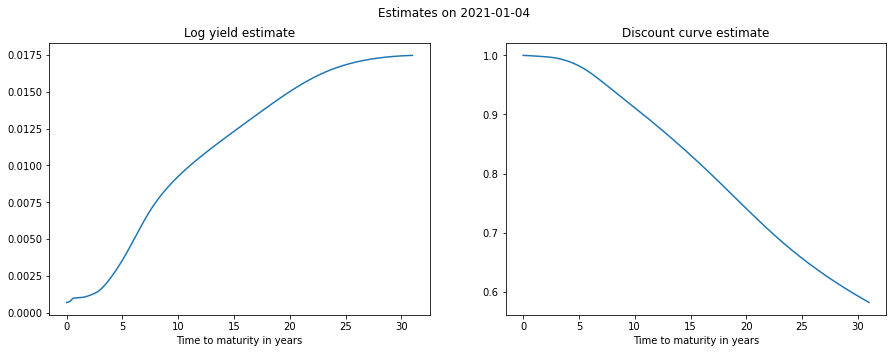

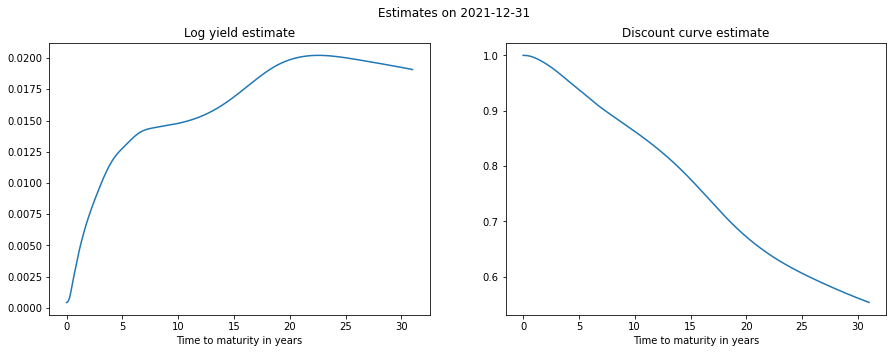

In [7]:
dates = [df_B_mat.index[0], df_B_mat.index[-1]]

for date in dates:
    fig = plt.figure(figsize=(15, 5))
    ax_1, ax_2 = fig.add_subplot(1,2,1), fig.add_subplot(1,2,2)

    ax_1.plot(np.arange(1,1+Nmax)/365, df_y.loc[date])
    ax_2.plot(np.arange(1,1+Nmax)/365, df_g.loc[date])
    
    ax_1.set_title('Log yield estimate');
    ax_2.set_title('Discount curve estimate');
    fig.suptitle('Estimates on {}'.format(date.strftime('%Y-%m-%d')));
    
    for ax in [ax_1, ax_2]:
        ax.set_xlabel('Time to maturity in years');
        
    fig.savefig(dir_output+'estimates_{}.png'.format(date.strftime('%Y-%m-%d')))